### Input: 
Arrest data was exported on April 10th, 2024, with the lates update of the data on January 18, 2024.\
https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc/about_data

### Note:
In this file, it can be used to explain why our focus in in Brooklyn, and the data is solely in 2023.

### Need to Check:
1. null values in merged data
2. within vs. intersects
3. read 2263 from .prj files
4. default 4326, ctx 3857

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from shapely.wkt import loads
import calendar
import warnings
warnings.filterwarnings('ignore')

In [2]:
arrest = pd.read_csv('../../data/raw/NYPD_Arrest_Data__Year_to_Date__20240410.csv'); arrest.head(3)

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,261265483,01/03/2023,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1600500,F,B,49,0,18-24,M,BLACK,1027430,251104,40.855793,-73.843908,POINT (-73.843908 40.855793)
1,261271301,01/03/2023,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,S,120,0,25-44,M,WHITE,962808,174275,40.644996,-74.077263,POINT (-74.077263 40.644996)
2,261336449,01/04/2023,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1601001,F,K,61,0,<18,M,BLACK,995118,155708,40.594054,-73.960866,POINT (-73.960866 40.594054)


## Preprocessing

In [3]:
print(arrest.columns)
arrest = arrest[['ARREST_KEY', 'ARREST_DATE', 'OFNS_DESC', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT',
       'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD',
       'Y_COORD_CD', 'Latitude', 'Longitude', 'New Georeferenced Column']]

Index(['ARREST_KEY', 'ARREST_DATE', 'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC',
       'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT',
       'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD',
       'Y_COORD_CD', 'Latitude', 'Longitude', 'New Georeferenced Column'],
      dtype='object')


### Sanity Check

In [4]:
# check if the unqiue values of ARREST_BORO are corresponding to 5 boroughs: K represents Brooklyn based on the data dictionary
print(arrest.ARREST_BORO.unique())

['B' 'S' 'K' 'Q' 'M']


The shape of original data is: (226872, 15)



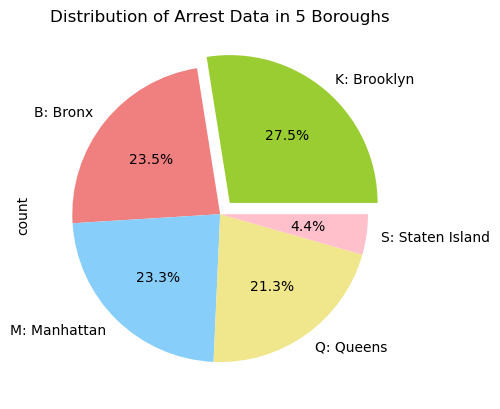


The shape of Brooklyn data is: (62395, 15), which is around 27.5% of original data


In [5]:
print('The shape of original data is:', arrest.shape)
print()
# Plotting the pie chart
plt.figure()
labels = ['K: Brooklyn', 'B: Bronx', 'M: Manhattan', 'Q: Queens', 'S: Staten Island']
colors = ['yellowgreen', 'lightcoral', 'lightskyblue', 'khaki', 'pink']
explode = (0.1, 0, 0, 0, 0)  
arrest['ARREST_BORO'].value_counts().plot(kind='pie', autopct='%1.1f%%', explode=explode, colors=colors, labels=labels)
plt.title('Distribution of Arrest Data in 5 Boroughs')

plt.show()
print()

arrest_bk = arrest[arrest.ARREST_BORO == 'K']
print(f'The shape of Brooklyn data is: {arrest_bk.shape}, which is around {round(100*(arrest_bk.shape[0]/arrest.shape[0]), 2)}% of original data')

In [6]:
# filter out those with either OFNS_DESC or LAW_CAT_CD are equal to '(null)'
if len(arrest_bk[((arrest_bk.OFNS_DESC == '(null)') | (arrest_bk.LAW_CAT_CD == '(null)'))]) > 0:
    arrest_bk = arrest_bk[~((arrest_bk.OFNS_DESC == '(null)') | (arrest_bk.LAW_CAT_CD == '(null)'))]
    print('After fileter out those with either OFNS_DESC or LAW_CAT_CD equal to \'(null)\', the shape is:', arrest_bk.shape)
else:
    print('No \"either OFNS_DESC or LAW_CAT_CD equal\"" found!')
# filter out those with both OFNS_DESC and LAW_CAT_CD be null values
if len(arrest_bk[((arrest_bk.OFNS_DESC.isnull()) & (arrest_bk.LAW_CAT_CD.isnull()))]):
    arrest_bk = arrest_bk[~((arrest_bk.OFNS_DESC.isnull()) & (arrest_bk.LAW_CAT_CD.isnull()))]
    print('After fileter out those with both OFNS_DESC and LAW_CAT_CD be null values, the shape is:', arrest_bk.shape)
else:
    print('No \"OFNS_DESC being null and LAW_CAT_CD being null simultaneously\" found!')
# filter out those with either OFNS_DESC or LAW_CAT_CD be null values
if len(arrest_bk[((arrest_bk.OFNS_DESC.isnull()) | (arrest_bk.LAW_CAT_CD.isnull()))]):
    arrest_bk = arrest_bk[~((arrest_bk.OFNS_DESC.isnull()) | (arrest_bk.LAW_CAT_CD.isnull()))]
    print('After fileter out those with either OFNS_DESC or LAW_CAT_CD be null values, the shape is:', arrest_bk.shape)
else:
    print('No \"OFNS_DESC being null and LAW_CAT_CD being null simultaneously\" found!')
# filter out those LAW_CAT_CD == '9'
if len(arrest_bk[arrest_bk.LAW_CAT_CD == '9']) > 0:
    arrest_bk = arrest_bk[arrest_bk.LAW_CAT_CD != '9']
    print('After fileter out those LAW_CAT_CD == \'9\', the shape is:', arrest_bk.shape)
else:
    print('No LAW_CAT_CD == \'9\' found!')

# combining V and I into one category V/I in column LAW_CAT_CD
arrest_bk['LAW_CAT_CD'] = arrest_bk['LAW_CAT_CD'].replace({'V': 'V/I', 'I': 'V/I'})

After fileter out those with either OFNS_DESC or LAW_CAT_CD equal to '(null)', the shape is: (62390, 15)
No "OFNS_DESC being null and LAW_CAT_CD being null simultaneously" found!
After fileter out those with either OFNS_DESC or LAW_CAT_CD be null values, the shape is: (62190, 15)
After fileter out those LAW_CAT_CD == '9', the shape is: (62178, 15)


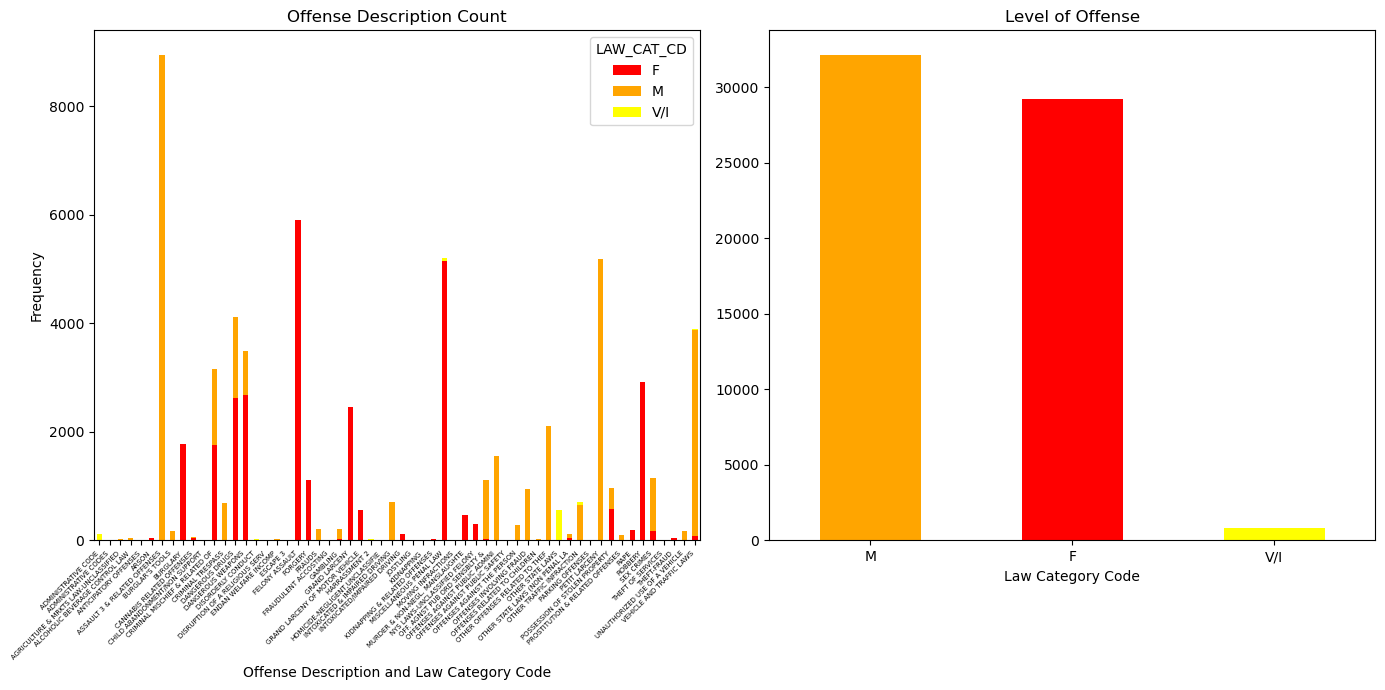

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

grouped = arrest_bk.groupby(['OFNS_DESC','LAW_CAT_CD']).size().sort_values(ascending=False).unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True, color=['r','orange','yellow'], ax=axes[0])
axes[0].set_title('Offense Description Count')
axes[0].set_xlabel('Offense Description and Law Category Code')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', which='major', labelsize=5)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

arrest_bk['LAW_CAT_CD'].value_counts().plot(kind='bar', color=['orange','r','yellow'], ax=axes[1])
axes[1].set_title('Level of Offense')
axes[1].set_xlabel('Law Category Code')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()

plt.show()

In [8]:
arrest['ARREST_DATE'] = pd.to_datetime(arrest['ARREST_DATE'])
arrest['ARREST_DATE'].dt.year.unique()

array([2023])

In [9]:
arrest_bk['ARREST_DATE'] = pd.to_datetime(arrest_bk['ARREST_DATE'])

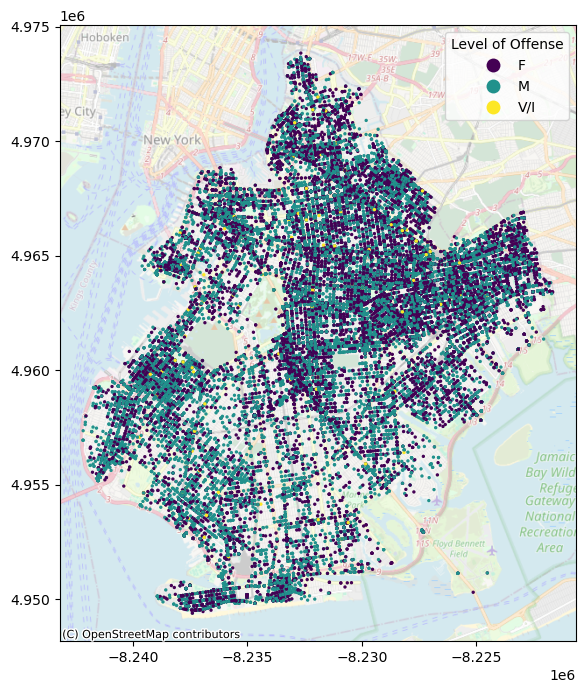

In [10]:
gdf = gpd.GeoDataFrame(arrest_bk, geometry=gpd.points_from_xy(arrest_bk['Longitude'], arrest_bk['Latitude']))

gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=3857) # in order to match the base map

fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, column='LAW_CAT_CD', legend=True, markersize=2, categorical=True, cmap='viridis', legend_kwds={'title': 'Level of Offense'})
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

plt.show()

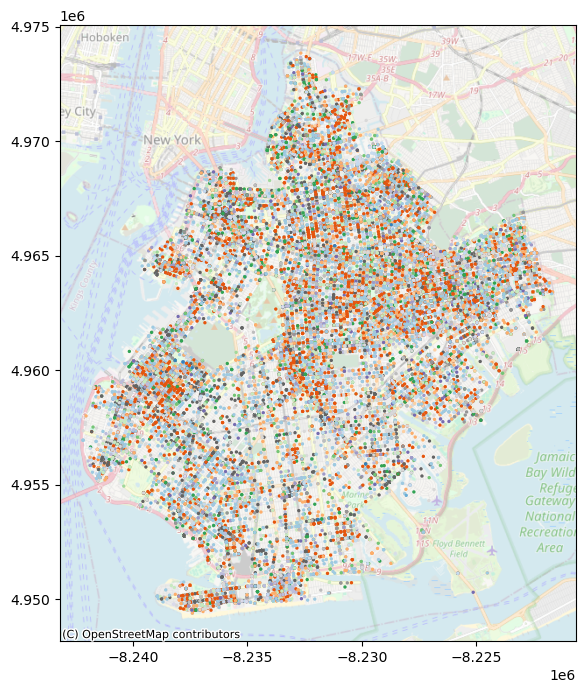

In [11]:
gdf = gpd.GeoDataFrame(arrest_bk, geometry=gpd.points_from_xy(arrest_bk['Longitude'], arrest_bk['Latitude']))

gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=3857) # in order to match the base map

fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, column='OFNS_DESC', legend=False, markersize=2, categorical=True, cmap='tab20c', legend_kwds={'title': 'Description of Internal Classification'})
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

plt.show()

## Merge with Zipcode and Do Statistics

In [12]:
zipcode = gpd.read_file("../../data/processed_data/zipcode_bk.shp"); zipcode.head(3)

,ZIPCODE,PO_NAME,POPULATION,AREA,ST_FIPS,CTY_FIPS,geometry
0,11213,Brooklyn,62426.0,2.963100e+07,36,047,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
1,11212,Brooklyn,83866.0,4.197210e+07,36,047,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
2,11225,Brooklyn,56527.0,2.369863e+07,36,047,"POLYGON ((995908.365 183617.613, 996522.848 18..."


In [13]:
zipcode_gdf = gpd.GeoDataFrame(zipcode, geometry=zipcode['geometry'], crs="EPSG:2263") # this is recorded in .prj file
gdf = gdf.to_crs(epsg=2263)
arrest_zipcode = gpd.sjoin(gdf, zipcode_gdf, how="left", op='intersects')
arrest_zipcode.head(3)

,ARREST_KEY,ARREST_DATE,OFNS_DESC,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,...,Longitude,New Georeferenced Column,geometry,index_right,ZIPCODE,PO_NAME,POPULATION,AREA,ST_FIPS,CTY_FIPS
2,261336449,2023-01-04,ROBBERY,F,K,61,0,<18,M,BLACK,...,-73.960866,POINT (-73.960866 40.594054),POINT (995118.352 155708.729),32.0,11223.0,Brooklyn,79864.0,5.870292e+07,36,047
5,261583093,2023-01-08,FELONY ASSAULT,F,K,76,0,25-44,M,BLACK,...,-74.000504,POINT (-74.000504 40.683691),POINT (984110.216 188363.492),19.0,11231.0,Brooklyn,33144.0,3.937969e+07,36,047
7,261892107,2023-01-14,FELONY ASSAULT,F,K,90,0,25-44,M,BLACK,...,-73.955662,POINT (-73.955662 40.714082),POINT (996541.480 199438.946),38.0,11211.0,Brooklyn,60861.0,4.047088e+07,36,047


<Axes: >

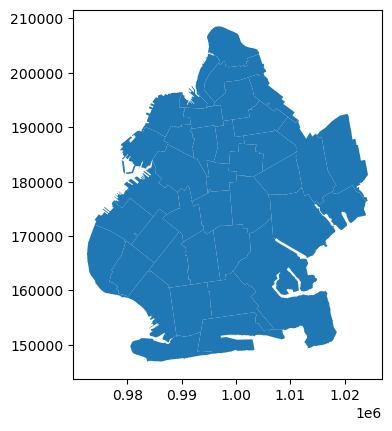

In [14]:
zipcode_gdf.plot()

In [15]:
null_counts = arrest_zipcode.isnull().sum()
print(null_counts)

ARREST_KEY                    0
ARREST_DATE                   0
OFNS_DESC                     0
LAW_CAT_CD                    0
ARREST_BORO                   0
ARREST_PRECINCT               0
JURISDICTION_CODE             0
AGE_GROUP                     0
PERP_SEX                      0
PERP_RACE                     0
X_COORD_CD                    0
Y_COORD_CD                    0
Latitude                      0
Longitude                     0
New Georeferenced Column      0
geometry                      0
index_right                 665
ZIPCODE                     665
PO_NAME                     665
POPULATION                  665
AREA                        665
ST_FIPS                     665
CTY_FIPS                    665
dtype: int64


In [16]:
arrest_zipcode = arrest_zipcode[~arrest_zipcode.isnull().any(axis=1)]

In [17]:
column_chosen = []
for col in list(arrest_zipcode.columns):
    if len(arrest_zipcode[col].unique()) == 1:
        column_chosen.append(col)
        print(f'There is only 1 unique value in column {col}, which is {arrest_zipcode[col].unique()}')

There is only 1 unique value in column ARREST_BORO, which is ['K']
There is only 1 unique value in column PO_NAME, which is ['Brooklyn']
There is only 1 unique value in column ST_FIPS, which is ['36']
There is only 1 unique value in column CTY_FIPS, which is ['047']


In [18]:
arrest_zipcode = arrest_zipcode.drop('ARREST_BORO', axis=1)

### Calculate the Statisitcs

In [19]:
arrest_zipcode.head(3)

,ARREST_KEY,ARREST_DATE,OFNS_DESC,LAW_CAT_CD,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,...,Longitude,New Georeferenced Column,geometry,index_right,ZIPCODE,PO_NAME,POPULATION,AREA,ST_FIPS,CTY_FIPS
2,261336449,2023-01-04,ROBBERY,F,61,0,<18,M,BLACK,995118,...,-73.960866,POINT (-73.960866 40.594054),POINT (995118.352 155708.729),32.0,11223.0,Brooklyn,79864.0,5.870292e+07,36,047
5,261583093,2023-01-08,FELONY ASSAULT,F,76,0,25-44,M,BLACK,984110,...,-74.000504,POINT (-74.000504 40.683691),POINT (984110.216 188363.492),19.0,11231.0,Brooklyn,33144.0,3.937969e+07,36,047
7,261892107,2023-01-14,FELONY ASSAULT,F,90,0,25-44,M,BLACK,996541,...,-73.955662,POINT (-73.955662 40.714082),POINT (996541.480 199438.946),38.0,11211.0,Brooklyn,60861.0,4.047088e+07,36,047


In [20]:
arrest_zipcode['month'] = arrest_zipcode['ARREST_DATE'].dt.month

In [21]:
arrest_zipcode.head(3)

,ARREST_KEY,ARREST_DATE,OFNS_DESC,LAW_CAT_CD,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,...,New Georeferenced Column,geometry,index_right,ZIPCODE,PO_NAME,POPULATION,AREA,ST_FIPS,CTY_FIPS,month
2,261336449,2023-01-04,ROBBERY,F,61,0,<18,M,BLACK,995118,...,POINT (-73.960866 40.594054),POINT (995118.352 155708.729),32.0,11223.0,Brooklyn,79864.0,5.870292e+07,36,047,1
5,261583093,2023-01-08,FELONY ASSAULT,F,76,0,25-44,M,BLACK,984110,...,POINT (-74.000504 40.683691),POINT (984110.216 188363.492),19.0,11231.0,Brooklyn,33144.0,3.937969e+07,36,047,1
7,261892107,2023-01-14,FELONY ASSAULT,F,90,0,25-44,M,BLACK,996541,...,POINT (-73.955662 40.714082),POINT (996541.480 199438.946),38.0,11211.0,Brooklyn,60861.0,4.047088e+07,36,047,1


In [22]:
arrest_zipcode.groupby(['ZIPCODE', 'LAW_CAT_CD']).size()

ZIPCODE  LAW_CAT_CD
11201.0  F             1389
         M             1933
         V/I             26
11203.0  F              694
         M              781
                       ... 
11249.0  M              183
         V/I              6
11251.0  F               27
         M               60
         V/I              3
Length: 116, dtype: int64

In [23]:
arrest_zipcode.columns

Index(['ARREST_KEY', 'ARREST_DATE', 'OFNS_DESC', 'LAW_CAT_CD',
       'ARREST_PRECINCT', 'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX',
       'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'New Georeferenced Column', 'geometry', 'index_right', 'ZIPCODE',
       'PO_NAME', 'POPULATION', 'AREA', 'ST_FIPS', 'CTY_FIPS', 'month'],
      dtype='object')

In [24]:
arrest_zipcode['ZIPCODE'] = arrest_zipcode['ZIPCODE'].astype(int)

In [25]:
pd.crosstab(arrest_zipcode['ZIPCODE'], arrest_zipcode['month']).sum().sum()

61563

In [26]:
monthlyArrestCounts = pd.crosstab(arrest_zipcode['ZIPCODE'], arrest_zipcode['month'])
# rename the columns
monthlyArrestCounts.columns = [calendar.month_abbr[month] for month in monthlyArrestCounts.columns]
monthlyArrestCounts.columns = [f'{month}_ArrestCounts' for month in monthlyArrestCounts.columns]

In [27]:
summary = arrest_zipcode.groupby('ZIPCODE').agg(
    ArrestCount=pd.NamedAgg(column='ARREST_KEY', aggfunc='size'),
    population=pd.NamedAgg(column='POPULATION', aggfunc='mean'), 
    geometry=pd.NamedAgg(column='geometry', aggfunc='first')
)

summary = summary.join(monthlyArrestCounts, on='ZIPCODE')

In [28]:
summary.columns

Index(['ArrestCount', 'population', 'geometry', 'Jan_ArrestCounts',
       'Feb_ArrestCounts', 'Mar_ArrestCounts', 'Apr_ArrestCounts',
       'May_ArrestCounts', 'Jun_ArrestCounts', 'Jul_ArrestCounts',
       'Aug_ArrestCounts', 'Sep_ArrestCounts', 'Oct_ArrestCounts',
       'Nov_ArrestCounts', 'Dec_ArrestCounts'],
      dtype='object')

In [30]:
summary.to_csv("../../data/processed_data/arrest_statistics.csv")

In [31]:
summary

,ArrestCount,population,geometry,Jan_ArrestCounts,Feb_ArrestCounts,Mar_ArrestCounts,Apr_ArrestCounts,May_ArrestCounts,Jun_ArrestCounts,Jul_ArrestCounts,Aug_ArrestCounts,Sep_ArrestCounts,Oct_ArrestCounts,Nov_ArrestCounts,Dec_ArrestCounts
ZIPCODE,,,,,,,,,,,,,,,
11201,3348,53041.0,POINT (989463.430 190450.199),272,263,292,268,338,277,275,290,275,260,288,250
11203,1476,78060.0,POINT (1002419.206 180820.667),117,129,124,108,148,131,124,147,111,120,126,91
11204,770,77354.0,POINT (988176.002 163891.999),39,56,64,69,77,68,63,72,66,66,83,47
11205,1067,41125.0,POINT (991150.366 192509.445),100,84,96,70,97,75,74,109,98,94,96,74
11206,2463,83575.0,POINT (1002439.534 198129.236),216,170,222,202,205,209,254,186,181,231,206,181
11207,3881,93556.0,POINT (1013654.480 177162.151),309,311,377,311,353,367,322,323,270,313,337,288
11208,3561,94410.0,POINT (1017119.365 183909.215),269,263,271,283,335,312,281,340,313,328,302,264
11209,876,69255.0,POINT (976380.002 166179.999),91,71,99,61,70,73,62,75,53,50,84,87
11210,1511,67067.0,POINT (1000520.521 168264.234),116,105,114,114,102,149,132,133,131,144,157,114


In [32]:
summary.shape

(39, 15)